In [1]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self,X,*args):
        raise NotImplementedError



In [2]:
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
    def forward(self,X,*args):
        raise NotImplementedError

In [3]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,enc_X,dec_X,*args):
        enc_outputs =self.encoder(enc_X,*args)
        dec_state = self.decoder.init_state(enc_outputs,*args)
        return self.decoder(dec_X,dec_state)

In [4]:
import collections
import math
import dltools

In [5]:
class Seq2SeqEncoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)
    def forward(self,X,*args):
        X = self.embedding(X)
        X= X.permute(1,0,2)
        output,state = self.rnn(X)
        return output,state

In [6]:
import torch


encoder = Seq2SeqEncoder(vocab_size=200,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
X=torch.zeros((4,7),dtype = torch.long)
output,state = encoder(X)
output.shape,state[0].shape

(torch.Size([7, 4, 16]), torch.Size([4, 16]))

In [7]:
class Seq2SeqDecoder(Decoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layer,dropout=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens,num_hiddens,num_layer,dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    def forward(self,X,state):
        X = self.embedding(X).permute(1,0,2)
        context = state[-1].repeat(X.shape[0],1,1)
        X_and_context = torch.cat((X,context),2)
        output,state = self.rnn(X_and_context,state)
        output = self.dense(output).permute(1,0,2)
        return output,state
decoder = Seq2SeqDecoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layer=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output,state = decoder(X,state)
output.shape,state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [8]:

def sequence_mask(X,valid_len,value = 0):
    maxlen = X.size(1)
    print(maxlen)
    mask = torch.arange((maxlen),dtype=torch.float32,device=X.device)[None]<valid_len[:,None]
    print(mask)
    X[~mask] = value
    return X


In [9]:
X=torch.tensor([[1,2,3],[4,5,6]])
sequence_mask(X,torch.tensor([1,2]))

3
tensor([[ True, False, False],
        [ True,  True, False]])


tensor([[1, 0, 0],
        [4, 5, 0]])

In [10]:
class MaskedSoftMaxCELoss(nn.CrossEntropyLoss):
    def forward(self,pred,label,valid_len):
        weight = torch.ones_like(label)
        weight = sequence_mask(weight,valid_len,0)
        self.reduction = 'none'
        unweighted_loss = super().forward(pred.permute(0,2,1),label)
        weight_loss = (unweighted_loss * weight).mean(dim=1)
        return weight_loss
loss = MaskedSoftMaxCELoss()
loss.forward(torch.ones(3,4,20),torch.ones((3,4),dtype=torch.long),torch.tensor([4,2,0]))

4
tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [False, False, False, False]])


tensor([2.9957, 1.4979, 0.0000])

In [11]:
def train_seq2seq(net,data_iter,lr,num_epochs,tgt_vocab,device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    loss = MaskedSoftMaxCELoss()
    animator = dltools.Animator(xlabel='epoch',ylabel='loss',xlim=[10,num_epochs])
    for epoch in range(num_epochs):
        timer = dltools.Timer()
        metric = dltools.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X,X_valid_len,Y,Y_valid_len  = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1,1)
            dec_input = torch.cat([bos,Y[:,:-1]],1)
            Y_hat,_ =  net(X,dec_input,X_valid_len)
            l = loss(Y_hat,Y,Y_valid_len)
            l.sum().backward()
            dltools.grad_clipping(net,1)
            num_token = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(),num_token)
        if (epoch +1 )% 10 ==0:
            animator.add(epoch+1,(metric[0]/metric[1]))
    print(f'loss {metric[0]/metric[1]:.3f},{metric[1]/timer.stop():.1f}',f'tokens/sec on {str(device)}')

loss 0.027,10677.8 tokens/sec on cuda:0


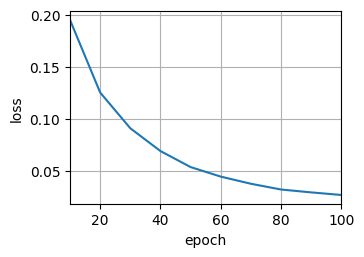

In [12]:
embed_size,num_hiddens,num_layers,dropout = 32,32,2,0.1
batch_size,num_steps = 64,10
lr,num_epoches,device = 0.005,100,dltools.try_gpu()
train_iter,src_vocab,tgt_vocab = dltools.load_data_nmt(batch_size,num_steps)
encoder = Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab),embed_size,num_hiddens,num_layers,dropout)
net = EncoderDecoder(encoder,decoder)
train_seq2seq(net,train_iter,lr,num_epoches,tgt_vocab,device)

In [18]:
def predicted_seq2seq(net,src_sentence,src_vocab,tgt_vocab,num_steps,device):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]

    enc_validlen = torch.tensor([len(src_tokens)],device=device)
    src_tokens = dltools.truncate_pad(src_tokens,num_steps,src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens,dtype=torch.long,device=device),dim = 0)
    enc_outputs = net.encoder(enc_X,enc_validlen)
    dec_state = net.decoder.init_state(enc_outputs,enc_validlen)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']],dtype=torch.long,device=device),dim=0)
    output_seq = []
    for _ in range(num_steps):
        Y,dec_state = net.decoder(dec_X,dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim = 0).type(torch.int32).item()
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

In [16]:
import math, collections

def bleu(pred_seq, label_seq, k):
    pred_tokens = pred_seq.split(' ')
    label_tokens = label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)

    # ---- Brevity Penalty (长度惩罚项)
    score = math.exp(min(0, 1 - len_label / len_pred))

    # ---- n-gram 精确率累积部分
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        
        # 构造参考句的 n-gram 计数
        for i in range(len_label - n + 1):
            ngram = ' '.join(label_tokens[i:i+n])
            label_subs[ngram] += 1

        # 匹配预测句中的 n-gram
        for i in range(len_pred - n + 1):
            ngram = ' '.join(pred_tokens[i:i+n])
            if label_subs[ngram] > 0:
                num_matches += 1
                label_subs[ngram] -= 1  # 避免重复计数

        # 防止除 0
        if len_pred - n + 1 == 0:
            precision_n = 0
        else:
            precision_n = num_matches / (len_pred - n + 1)

        # 用对数平均（标准 BLEU 公式）
        if precision_n > 0:
            score *= math.pow(precision_n, 0.5 ** n)
        else:
            score *= 0

    return score


In [19]:
# ------------------ 测试若干英语句并输出翻译及 BLEU ------------------
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    # 调用你前面定义的单句预测函数
    translation = predicted_seq2seq(net, eng, src_vocab, tgt_vocab,
                                   num_steps=num_steps, device=device)
    # 计算 BLEU@2
    bleu_score = bleu(translation, fra, k=2)
    print(f"{eng:10s} => {translation:40s} , bleu {bleu_score:.3f}")


go .       => va !                                     , bleu 1.000
i lost .   => j'ai perdu .                             , bleu 1.000
he's calm . => il est est riche .                       , bleu 0.548
i'm home . => je suis malade .                         , bleu 0.512
